In [ ]:
!pip install torchcam

In [ ]:
#Importing required libraries
import torch
import torch.nn as nn
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, models
from torchvision.transforms.functional import to_pil_image
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score, classification_report
from torchcam.utils import overlay_mask
from PIL import Image
from torchcam.methods import GradCAM
import random


In [ ]:
# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
# Defining hyperparameters and constants
BATCH_SIZE = 32
IMAGE_SIZE = 224
LEARNING_RATE = 0.001
NUM_EPOCHS = 10
TRAIN_SPLIT_RATIO = 0.8

In [ ]:
# 1. Loading the Oxford-IIIT Pets dataset from Torchvision datasets
def load_data():
    transform = transforms.Compose([
        transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
        transforms.ToTensor(),
    ])
    dataset = datasets.OxfordIIITPet(root='./data', split='trainval', download=True, transform=transform)
    test_dataset = datasets.OxfordIIITPet(root='./data', split='test', download=True, transform=transform)
    return dataset, test_dataset

In [ ]:
# 2. Splitting the train partition into training and validation sets (80% training, 20% validation)
def split_data(dataset):
    train_size = int(TRAIN_SPLIT_RATIO * len(dataset))
    val_size = len(dataset) - train_size
    train_dataset, val_dataset = random_split(dataset, [train_size, val_size])
    return train_dataset, val_dataset

In [ ]:
# Loading the data
dataset, test_dataset = load_data()
train_dataset, val_dataset = split_data(dataset)

In [ ]:
def show_class_distribution(dataset):
    class_counts = [0] * len(dataset.dataset.classes)
    for _, label in dataset:
        class_counts[label] += 1

    # Set the figure size to be larger
    plt.figure(figsize=(12, 8))

    # Create the bar chart
    plt.bar(dataset.dataset.classes, class_counts, color='skyblue')

    # Set the labels and title
    plt.xlabel('Classes')
    plt.ylabel('Number of Images')
    plt.title('Class Distribution of Training Partition')

    # Rotate the x-ticks to show class names vertically
    plt.xticks(rotation=90)

    # Display the plot
    plt.show()


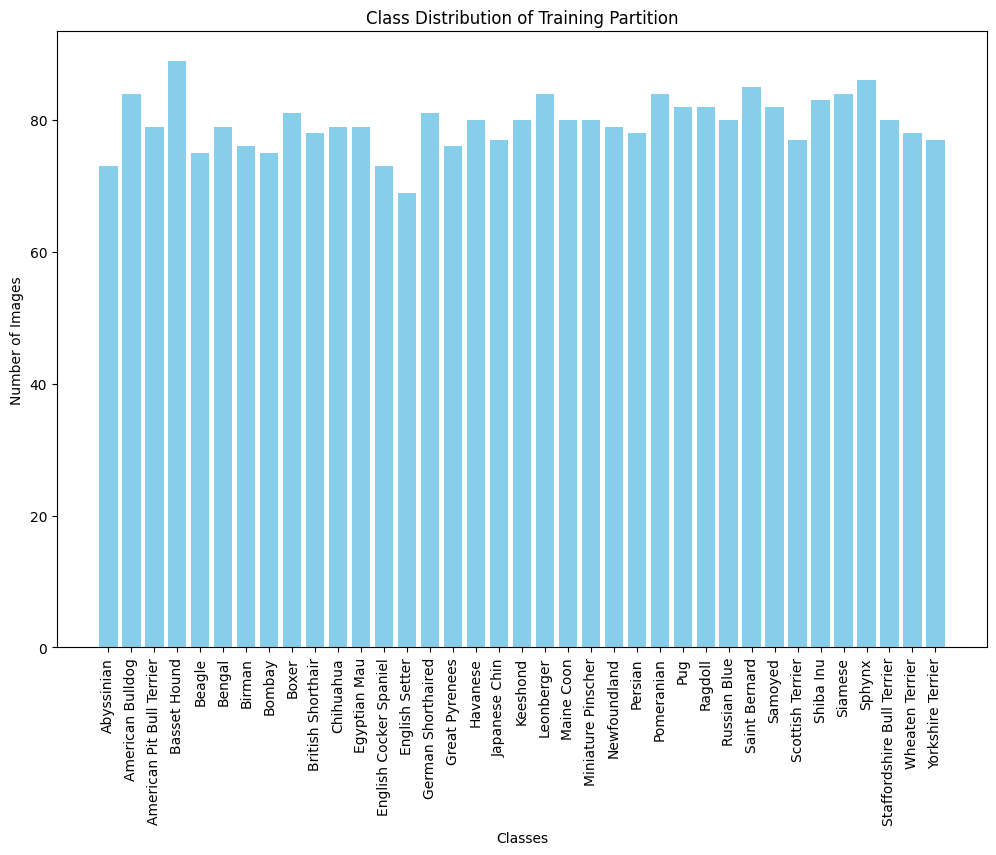

In [ ]:
# Show class distribution on training set
show_class_distribution(train_dataset)

In [ ]:
# 4. Defining and setting the Dataloaders
def create_dataloaders(train_dataset, val_dataset, test_dataset):
    train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)
    return train_loader, val_loader, test_loader

In [ ]:
# Creating the data loaders
train_loader, val_loader, test_loader = create_dataloaders(train_dataset, val_dataset, test_dataset)

In [ ]:
# 5. Load pretrained ResNet-18 model
def load_pretrained_resnet():
    model = models.resnet18(weights=models.ResNet18_Weights.DEFAULT).to(device)
    return model

In [ ]:
# 6. Modifying the ResNet-18 for Oxford-IIIT Pets dataset
def modify_resnet(model, num_classes):
    # Removing the final fully connected layer and adding a GAP and 1x1 Conv layer for classification
    model = nn.Sequential(
        *list(model.children())[:-2],  # Keeping the layers up to the last convolutional layer
        nn.AdaptiveAvgPool2d((1, 1)),  # GAP layer
        nn.Conv2d(512, num_classes, kernel_size=1)  # 1x1 Conv is done for the final classification
    )
    return model.to(device)

In [ ]:
# Load and modify pretrained ResNet-18 model
model = load_pretrained_resnet()
model = modify_resnet(model, num_classes=len(dataset.classes))

In [ ]:
# Adjusted train_model function
def train_model(model, train_loader, val_loader, num_epochs=10, learning_rate=0.001):
    optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9)
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)
    criterion = nn.CrossEntropyLoss()

    train_losses, val_losses = [], []

    for epoch in range(num_epochs):
        model.train()
        running_train_loss = 0.0

        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()

            # Forward pass
            outputs = model(inputs)
            outputs = outputs.view(outputs.size(0), -1)  # Flatten to [batch_size, num_classes]

            # Compute loss
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_train_loss += loss.item() * inputs.size(0)

        epoch_train_loss = running_train_loss / len(train_loader.dataset)
        train_losses.append(epoch_train_loss)

        # Validation phase
        model.eval()
        running_val_loss = 0.0

        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                outputs = outputs.view(outputs.size(0), -1)  # Flatten to [batch_size, num_classes]

                val_loss = criterion(outputs, labels)
                running_val_loss += val_loss.item() * inputs.size(0)

        epoch_val_loss = running_val_loss / len(val_loader.dataset)
        val_losses.append(epoch_val_loss)

        scheduler.step()

        print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {epoch_train_loss:.4f}, Val Loss: {epoch_val_loss:.4f}")

    return train_losses, val_losses

In [ ]:
# Plotting training and validation loss
def plot_losses(train_losses, val_losses):
    plt.figure(figsize=(10, 5))
    plt.plot(train_losses, label='Training Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()
    plt.show()

Epoch 1/10, Train Loss: 2.5693, Val Loss: 1.3582
Epoch 2/10, Train Loss: 0.9577, Val Loss: 0.7253
Epoch 3/10, Train Loss: 0.5473, Val Loss: 0.5428
Epoch 4/10, Train Loss: 0.3657, Val Loss: 0.4542
Epoch 5/10, Train Loss: 0.2703, Val Loss: 0.3953
Epoch 6/10, Train Loss: 0.2012, Val Loss: 0.3622
Epoch 7/10, Train Loss: 0.1603, Val Loss: 0.3344
Epoch 8/10, Train Loss: 0.1287, Val Loss: 0.3329
Epoch 9/10, Train Loss: 0.1311, Val Loss: 0.3292
Epoch 10/10, Train Loss: 0.1228, Val Loss: 0.3319


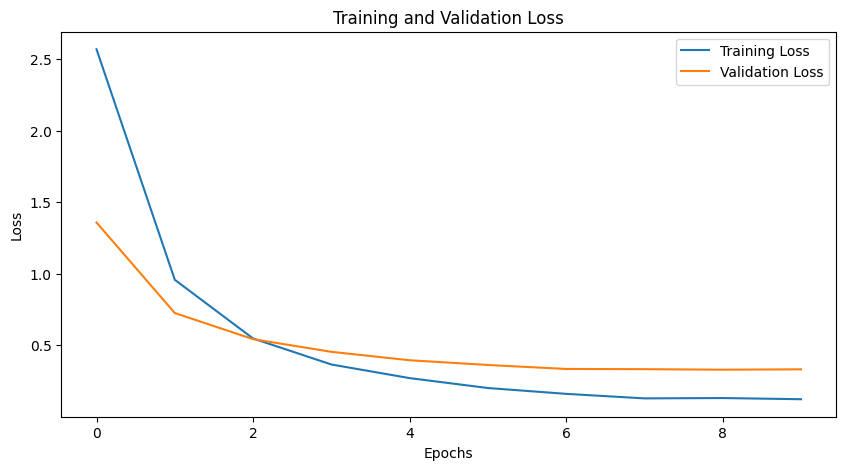

In [ ]:
# Train model
train_losses, val_losses = train_model(model, train_loader, val_loader)

# Plot losses
plot_losses(train_losses, val_losses)

In [ ]:
def evaluate_model(model, test_loader, classes):
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)

            # Get predicted class
            _, preds = torch.max(outputs, 1)

            # # Store predictions and labels
            all_preds.extend(preds.cpu().numpy().flatten().astype(int))
            all_labels.extend(labels.cpu().numpy().astype(int))

    # Checking the shapes and values
    # print("Sample of Predictions:", all_preds[:10])
    # print("Sample of Labels:", all_labels[:10])
    # print("Predictions and Labels length:", len(all_preds), len(all_labels))

    # Calculate metrics
    # try:
    accuracy = accuracy_score(all_labels, all_preds)
    f1 = f1_score(all_labels, all_preds, average='weighted')
    cm = confusion_matrix(all_labels, all_preds)
    # except ValueError as e:
    #     print("Error in metrics calculation:", e)
    #     return

    print(f"Accuracy: {accuracy * 100:.2f}%")
    print(f"F1 Score: {f1:.4f}")

    # Showing the classification report
    print(classification_report(all_labels, all_preds, target_names=dataset.classes))

    # Confusion matrix
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=classes, yticklabels=classes)
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title("Confusion Matrix")
    plt.show()

Accuracy: 89.10%
F1 Score: 0.8891
                            precision    recall  f1-score   support

                Abyssinian       0.88      0.86      0.87        98
          American Bulldog       0.71      0.88      0.79       100
 American Pit Bull Terrier       0.81      0.42      0.55       100
              Basset Hound       0.96      0.93      0.94       100
                    Beagle       0.90      0.94      0.92       100
                    Bengal       0.77      0.82      0.80       100
                    Birman       0.78      0.80      0.79       100
                    Bombay       0.86      0.98      0.91        88
                     Boxer       0.81      0.93      0.87        99
         British Shorthair       0.94      0.78      0.85       100
                 Chihuahua       0.87      0.77      0.81       100
              Egyptian Mau       0.91      0.88      0.89        97
    English Cocker Spaniel       0.93      0.88      0.90       100
            E

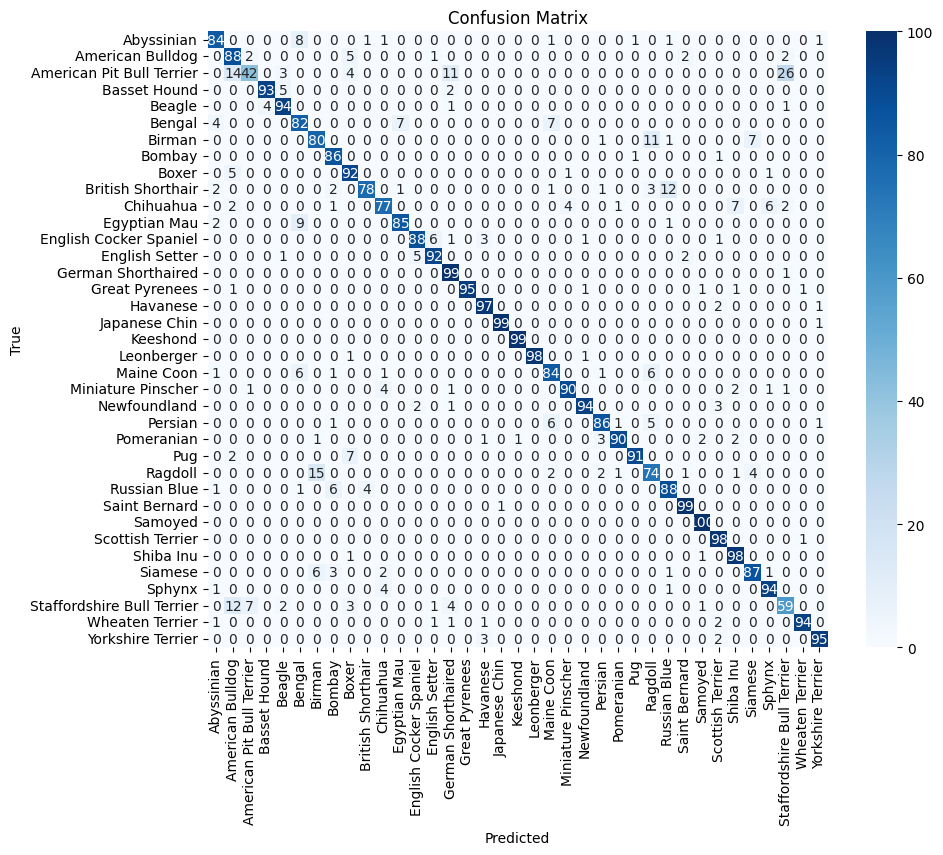

In [ ]:
# Evaluate model on test set
evaluate_model(model, test_loader, classes=dataset.classes)

In [ ]:
def grad_cam_visualization(model, test_loader):
    model.eval()

    # Enable gradients for Grad-CAM
    for param in model.parameters():
        param.requires_grad = True

    # Initialize Grad-CAM and specify the target layer (e.g., the last convolutional layer)
    cam_extractor = GradCAM(model, target_layer="7.1.conv2")  # Adjusting target_layer based on model architecture

    # Randomly sample 5 batches (each batch might contain multiple images)
    sampled_data = random.sample(list(test_loader), 5)

    for inputs, labels in sampled_data:
        inputs, labels = inputs.to(device), labels.to(device)

        # Forward pass
        outputs = model(inputs)

        # Process each image in the batch individually
        for i in range(inputs.size(0)):
            class_idx = labels[i].item()

            # Extract activation map for the specific class
            activation_map = cam_extractor(class_idx, outputs[i].unsqueeze(0), retain_graph=True)

            # Ensure activation_map is a tensor, not a list
            if isinstance(activation_map, list):
                activation_map = activation_map[0]

            # Average channels to get a single activation map
            activation_map = activation_map.mean(dim=0).unsqueeze(0)  # Shape: [1, H, W]

            # Resize and overlay the activation map on the original image
            activation_map_resized = transforms.functional.resize(
                to_pil_image(activation_map[0].cpu()), (IMAGE_SIZE, IMAGE_SIZE)
            )
            img = transforms.ToPILImage()(inputs[i].cpu())
            overlayed_img = overlay_mask(img, activation_map_resized, alpha=0.5, colormap='jet')

            plt.imshow(overlayed_img)
            plt.axis('off')
            plt.title(f"Grad-CAM for Class {class_idx}")
            plt.show()

In [ ]:
# Grad-CAM visualization
grad_cam_visualization(model, test_loader)